## Analytics with BigQuery Dataset

This is a sample notebook of formulating SQL queries to analyze data and with some basic data visualization.

# Setup Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# PostgreSQL Queries

We'll be analyzing an ecommerce dataset that contains information about clothing products sold online.

In [2]:
JSON_FILE = 'portfolio-sql-375904-67942b649e01.json'

from google.cloud import bigquery

client = bigquery.Client.from_service_account_json(JSON_FILE)

In [3]:
def extract_schema(table):
    database = 'bigquery-public-data.thelook_ecommerce.'
    
    return(client.get_table(database + table).schema)

This dataset contains several tables but for this case will only be focusing on three.

theLook Dataset Tables:
- order_items
- products
- distribution_centers

In [4]:
table = 'order_items'
extract_schema(table)

[SchemaField('id', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('order_id', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('user_id', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('product_id', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('inventory_item_id', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('status', 'STRING', 'NULLABLE', None, None, (), None),
 SchemaField('created_at', 'TIMESTAMP', 'NULLABLE', None, None, (), None),
 SchemaField('shipped_at', 'TIMESTAMP', 'NULLABLE', None, None, (), None),
 SchemaField('delivered_at', 'TIMESTAMP', 'NULLABLE', None, None, (), None),
 SchemaField('returned_at', 'TIMESTAMP', 'NULLABLE', None, None, (), None),
 SchemaField('sale_price', 'FLOAT', 'NULLABLE', None, None, (), None)]

In [5]:
table = 'products'
extract_schema(table)

[SchemaField('id', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('cost', 'FLOAT', 'NULLABLE', None, None, (), None),
 SchemaField('category', 'STRING', 'NULLABLE', None, None, (), None),
 SchemaField('name', 'STRING', 'NULLABLE', None, None, (), None),
 SchemaField('brand', 'STRING', 'NULLABLE', None, None, (), None),
 SchemaField('retail_price', 'FLOAT', 'NULLABLE', None, None, (), None),
 SchemaField('department', 'STRING', 'NULLABLE', None, None, (), None),
 SchemaField('sku', 'STRING', 'NULLABLE', None, None, (), None),
 SchemaField('distribution_center_id', 'INTEGER', 'NULLABLE', None, None, (), None)]

In [6]:
table = 'distribution_centers'
extract_schema(table)

[SchemaField('id', 'INTEGER', 'NULLABLE', None, None, (), None),
 SchemaField('name', 'STRING', 'NULLABLE', None, None, (), None),
 SchemaField('latitude', 'FLOAT', 'NULLABLE', None, None, (), None),
 SchemaField('longitude', 'FLOAT', 'NULLABLE', None, None, (), None)]

Reviewing the schemas we can see there is a lot of detailed information about the products and orders. So we need to run some queries to get an idea of the size of the market and where we want to start our analysis.

In [7]:
def query_df(query):
    return(client.query(query).result().to_dataframe())

In [8]:
q1 = (
    """
    SELECT COUNT(DISTINCT(product_id)) AS number_of_products, COUNT(DISTINCT(products.brand)) AS number_of_brands, COUNT(DISTINCT(products.category)) AS number_of_categorys
    FROM `bigquery-public-data.thelook_ecommerce.order_items`AS order_items
    INNER JOIN `bigquery-public-data.thelook_ecommerce.products` AS products ON products.id = order_items.product_id
    WHERE
        created_at BETWEEN "2022-01-01" AND "2023-01-01"
    """)

query_df(q1)

,number_of_products,number_of_brands,number_of_categorys
0,27592,2711,26


In [9]:
q2 = (
    """
    SELECT products.category, COUNT(order_items.id) AS units_sold
    FROM `bigquery-public-data.thelook_ecommerce.order_items`AS order_items
    INNER JOIN `bigquery-public-data.thelook_ecommerce.products` AS products ON products.id = order_items.product_id
    WHERE
        order_items.created_at BETWEEN "2022-01-01" AND "2023-01-01"
    GROUP BY
        products.category
    ORDER BY
        units_sold DESC
    LIMIT 10
    """)

query_df(q2)

,category,units_sold
0,Intimates,6165
1,Jeans,6025
2,Tops & Tees,5754
3,Fashion Hoodies & Sweatshirts,5607
4,Swim,5339
5,Shorts,5312
6,Sweaters,5307
7,Sleep & Lounge,5196
8,Accessories,4739
9,Outerwear & Coats,4313


So above we can see there are over 25,000 different products sold in 2022. The products are from over 2,500 different brands and broken up between 26 categorys. Due to the size of the market we are going to focus on one category, Tops & Tees. We are going do some exploratory analysis and look at the Mens department versus the Womens department in 2022. We are specifically going to look at;

- Who sold more units?
- Who had more options of products?
- Who has a higher average selling price?

I think the Womens department will have a higher demand over the year and more options then the Mens department but I think the average selling price will be close. Lets dive in and find out.

## TOPS & TEES

In [10]:
q3 = (
    """
    SELECT products.department, COUNT(order_items.id) AS total_units, CAST(SUM(order_items.sale_price) as int) AS total_sales, products.category
    FROM `bigquery-public-data.thelook_ecommerce.order_items`AS order_items
    INNER JOIN `bigquery-public-data.thelook_ecommerce.products` AS products ON products.id = order_items.product_id
    WHERE
        order_items.created_at BETWEEN "2022-01-01" AND "2023-01-01"
    GROUP BY
        products.department, products.category
    HAVING
        products.category = "Tops & Tees"
    ORDER BY
        total_units DESC
    """)

query_df(q3)

,department,total_units,total_sales,category
0,Men,3612,155828,Tops & Tees
1,Women,2142,86094,Tops & Tees


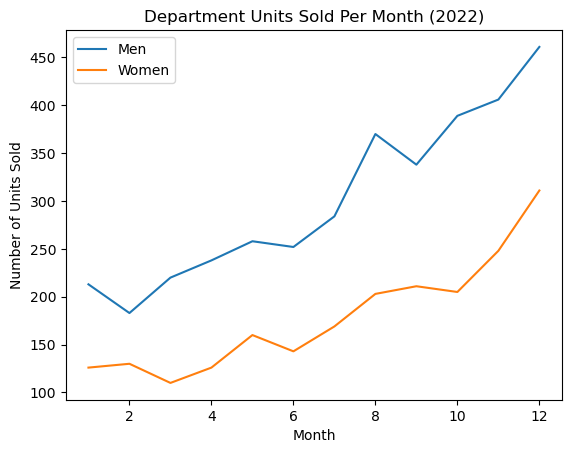

In [11]:
q4 = '''
    SELECT
        SUM(CASE WHEN products.department = 'Men' AND products.category = 'Tops & Tees' THEN products.retail_price/products.retail_price ELSE NULL END) AS units_men,
        SUM(CASE WHEN products.department = 'Women' AND products.category = 'Tops & Tees' THEN products.retail_price/products.retail_price ELSE NULL END) AS units_women,
        EXTRACT(YEAR FROM order_items.created_at) AS year_created,
        EXTRACT(MONTH FROM order_items.created_at) AS month_created
    FROM `bigquery-public-data.thelook_ecommerce.order_items` AS order_items
    INNER JOIN `bigquery-public-data.thelook_ecommerce.products` AS products ON products.id = order_items.product_id
    GROUP BY
        year_created, month_created
    HAVING
        year_created = 2022
    ORDER BY
        year_created, month_created
    '''
df4 = query_df(q4)
plt.plot(df4.month_created, df4.units_men, label = "Men")
plt.plot(df4.month_created, df4.units_women, label = "Women")
plt.title("Department Units Sold Per Month (2022)")
plt.xlabel("Month")
plt.ylabel("Number of Units Sold")
plt.legend()

Looking at table and graph above its clear the Mens department had a higher demand then the Womens department throughout the year selling 3,565 units compared to 2,019. Also, the Mens department generated 150,967 dollars in revenue and the Womens department generated 89,646 dollars in revenue.

Now lets specifically look at the Mens department...

In [12]:
q5 = (
    """
    SELECT COUNT(DISTINCT(product_id)) AS number_of_products, products.category, products.department
    FROM `bigquery-public-data.thelook_ecommerce.order_items`AS order_items
    INNER JOIN `bigquery-public-data.thelook_ecommerce.products` AS products ON products.id = order_items.product_id
    WHERE
        order_items.created_at BETWEEN "2022-01-01" AND "2023-01-01"
    GROUP BY
        products.category, products.department
    HAVING
        products.category = 'Tops & Tees' AND products.department = "Men"
    """)
query_df(q5)

,number_of_products,category,department
0,1044,Tops & Tees,Men


In [13]:
q6 = (
    """
    SELECT products.brand, COUNT(order_items.id) AS units_sold, AVG(sale_price) AS avg_price, products.category, products.department
    FROM `bigquery-public-data.thelook_ecommerce.order_items`AS order_items
    INNER JOIN `bigquery-public-data.thelook_ecommerce.products` AS products ON products.id = order_items.product_id
    WHERE
        order_items.created_at BETWEEN "2022-01-01" AND "2023-01-01"
    GROUP BY
        products.brand, products.category, products.department
    HAVING
        products.category = 'Tops & Tees' AND products.department = 'Men'
    ORDER BY
        units_sold DESC
    LIMIT 10
    """)

query_df(q6)

,brand,units_sold,avg_price,category,department
0,Carhartt,144,48.736597,Tops & Tees,Men
1,Van Heusen,125,38.711920,Tops & Tees,Men
2,U.S. Polo Assn.,121,30.937521,Tops & Tees,Men
3,Volcom,117,37.606667,Tops & Tees,Men
4,Harley-Davidson,105,31.236191,Tops & Tees,Men
5,DC,93,30.477957,Tops & Tees,Men
6,Columbia,85,58.681647,Tops & Tees,Men
7,Hurley,81,32.015679,Tops & Tees,Men
8,Tommy Hilfiger,79,37.618988,Tops & Tees,Men
9,Gildan,65,21.395692,Tops & Tees,Men


Looking at the first table, the Mens department sold 1,044 different Tops & Tees in 2022. The second table is more complex showing us the top 10 brands that sold most units along with their average price. This information is useful because it highlights the top vendors in the department and gives you an idea of their pricing. Now lets look at the average princing across the Mens department.

Text(0.5, 1.0, 'Mens Department Distinct Products Avg Prices (2022)')

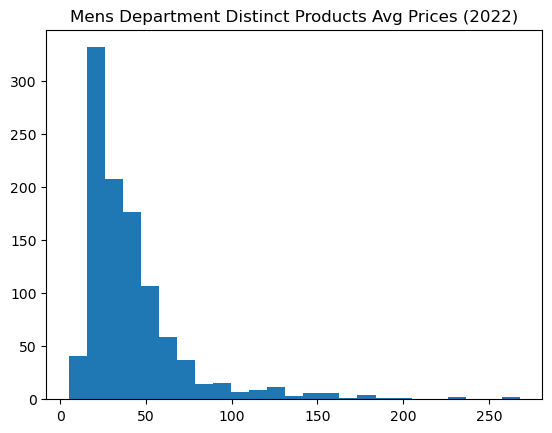

In [14]:
q7 = '''
    SELECT 
       DISTINCT(order_items.product_id), AVG(order_items.sale_price) AS avg_sale_price, products.category, products.department
    FROM `bigquery-public-data.thelook_ecommerce.order_items`AS order_items
    INNER JOIN `bigquery-public-data.thelook_ecommerce.products` AS products ON products.id = order_items.product_id
    WHERE
        order_items.created_at BETWEEN "2022-01-01" AND "2023-01-01"
    GROUP BY
        order_items.product_id, products.category, products.department
    HAVING
        products.category = 'Tops & Tees' AND products.department = 'Men'
    '''

df7 = query_df(q7)
plt.hist(df7.avg_sale_price, bins = 25)
plt.title("Mens Department Distinct Products Avg Prices (2022)")

So here we can see the distribution of the average sale price of distinct products for the Mens department is skewed to the right. It appears most of the products offered are probably between 30 and 50 dollars. The distribution mean looks to be around 40 dollars.

We will double check these conlusions later but lets move on to the Womens department.

In [15]:
q8 = (
    """
    SELECT COUNT(DISTINCT(product_id)) AS number_of_products, products.category, products.department
    FROM `bigquery-public-data.thelook_ecommerce.order_items`AS order_items
    INNER JOIN `bigquery-public-data.thelook_ecommerce.products` AS products ON products.id = order_items.product_id
    WHERE
        order_items.created_at BETWEEN "2022-01-01" AND "2023-01-01"
    GROUP BY
        products.category, products.department
    HAVING
        products.category = 'Tops & Tees' AND products.department = "Women"
    """)
query_df(q8)

,number_of_products,category,department
0,735,Tops & Tees,Women


In [16]:
q9 = (
    """
    SELECT products.brand, COUNT(order_items.id) AS units_sold, AVG(sale_price) AS avg_price, products.category, products.department
    FROM `bigquery-public-data.thelook_ecommerce.order_items`AS order_items
    INNER JOIN `bigquery-public-data.thelook_ecommerce.products` AS products ON products.id = order_items.product_id
    WHERE
        order_items.created_at BETWEEN "2022-01-01" AND "2023-01-01"
    GROUP BY
        products.brand, products.category, products.department
    HAVING
        products.category = 'Tops & Tees' AND products.department = 'Women'
    ORDER BY
        units_sold DESC
    LIMIT 10
    """)

query_df(q9)

,brand,units_sold,avg_price,category,department
0,Allegra K,296,10.741182,Tops & Tees,Women
1,Patty,131,32.269466,Tops & Tees,Women
2,Lucky Brand,67,59.111343,Tops & Tees,Women
3,Bella,49,25.680816,Tops & Tees,Women
4,Devon & Jones,46,32.611305,Tops & Tees,Women
5,eVogues Apparel,43,31.501629,Tops & Tees,Women
6,Next Level,41,23.125610,Tops & Tees,Women
7,American Apparel,41,23.146341,Tops & Tees,Women
8,Carhartt,32,40.327812,Tops & Tees,Women
9,Columbia,32,57.184688,Tops & Tees,Women


Above we can the see the Womens department sold 735 different Tops & Tees in 2022. The next table reveals the top 10 brands that sold most units along with their average price. This information highlights the top vendors in the Womens department and gives you an idea of their pricing. Now lets look at the average princing across the Womens department.

Text(0.5, 1.0, 'Womens Department Distinct Products Avg Prices (2022)')

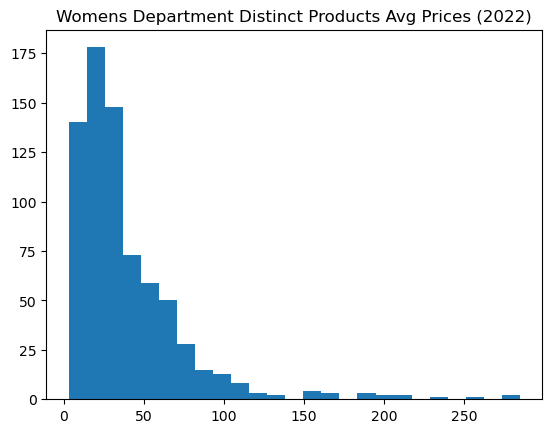

In [17]:
q10 = '''
    SELECT 
       DISTINCT(order_items.product_id), AVG(order_items.sale_price) AS avg_sale_price, products.category, products.department
    FROM `bigquery-public-data.thelook_ecommerce.order_items`AS order_items
    INNER JOIN `bigquery-public-data.thelook_ecommerce.products` AS products ON products.id = order_items.product_id
    WHERE
        order_items.created_at BETWEEN "2022-01-01" AND "2023-01-01"
    GROUP BY
        order_items.product_id, products.category, products.department
    HAVING
        products.category = 'Tops & Tees' AND products.department = 'Women'
    '''

df10 = query_df(q10)
plt.hist(df10.avg_sale_price, bins = 25)
plt.title("Womens Department Distinct Products Avg Prices (2022)")

The distribution above for the average sale price of distinct products for the Womens Department also appears to be skewed to the right. Most of the product appeat to be around 20 to 40 dollars and the distribution mean should be about 35 dollars.

Now lets compare both distributions...

C:\Users\Canas\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\Canas\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


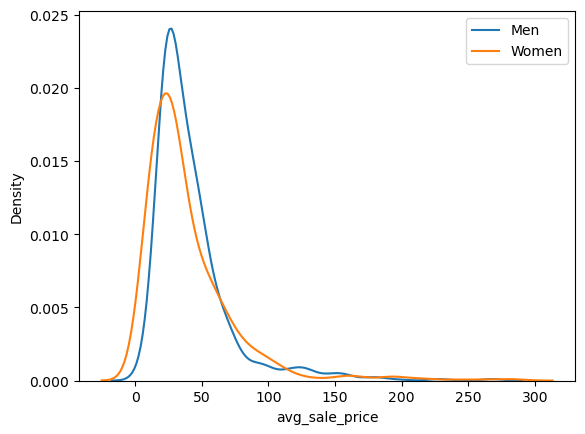

In [18]:
sns.distplot(df7.avg_sale_price, hist = False, label = "Men")
sns.distplot(df10.avg_sale_price, hist = False, label = "Women")
plt.legend()

Looking at both distributions, they are both skewed to the right but the Womens distributions is skewed a little more then the Mens. We can conclude that the distribution mean for the for the Womens department will be a little lower then the Mens department. Lets confirm with some basic statistics.

In [19]:
# Mens Department
df7.describe()

,product_id,avg_sale_price
count,1044.000000,1044.000000
mean,16532.475096,42.229052
std,312.598405,30.465706
min,15990.000000,5.000000
25%,16263.750000,24.950001
50%,16531.500000,32.990002
75%,16804.250000,49.500000
max,17076.000000,268.000000


In [20]:
# Womens Department
df10.describe()

,product_id,avg_sale_price
count,735.000000,735.000000
mean,391.751020,39.666150
std,224.697597,35.336733
min,1.000000,3.110000
25%,198.500000,19.500000
50%,393.000000,29.950001
75%,583.500000,49.500000
max,796.000000,285.000000


Conclusions:

- The Mens department had a higher count meaning they offered more products.
- The distribution mean for both departments are close but the Womens are a little lower.

My hypothesis at the begining was wrong. The Mens department has a clear control of the Tops & Tees sector. Although, the distribution mean were close. There is further analysis we could do with this dataset but this will suffice for now.